# Klustering Topik Dokumen Artikel Ilmiah pada Big Data Menggunakan Metode LDA

# *Research Paper Titles Topic Clustering on Big Data Using the LDA Method*
Oleh: Nabila Febriyanti (NIM 09021281823071)
## Dibuat Sebagai Tugas Besar Mata Kuliah Pengantar Big Data

### Deskripsi data
Data yang digunakan dalam pengujian ini adalah data judul artikel ilmiah berjulmah 50 ribu rows dari website https://arxiv.org/. 

Data diperoleh dari https://www.kaggle.com/tayorm/arxiv-papers-metadata.
### Deskripsi Program
Program ini membuat kluster dari data teks judul penelitian-penelitian. 


1.   **Persiapan data**: Dataframe dimuat kemudian dibersihka. Hasil proses ini adalah data frame dengan satu kolom judul artikel ilmiah.
2.   **Pra-pengolahan teks**: Proses ini mempersiapkan teks sebelum siap digunakan ke dalam model LDA. Hasil proses ini adalah korpus, kasus kata dan frekuensi
3. **Analisis data sederhana**: Dengan menggunakan data yang ada, dilakukan analisis sederhana menggunakan Pustaka cloudword untuk melihat sebaran kata kunci.
4. **Pembobotan/Vektorisasi dan Perbaikan Data**: Data diperbaiki dengan mencari frase berdasarkan frekuensi menggunakan alat bantu pustaka gensim. Deteksi frasa diperlukan untuk menangkap arti lebih baik terhadap teks. Data kemudian direpresentasikan menjadi bentuk vektor dengan metode TF-IDF. Kata dengan bobot rendah  diseleksi dan dibuang (reduksi fitur). Hasil proses ini adalah korpus dan kamus kata dan frekuensi siap pakai ke dalam model.
5. **Pelatihan Data ke dalam Model**: Memasukkan semua data yang diperlukan ke dalam model untuk dilakukan pemodelan clustering topik semantik dari judul artikel ilmiah
6. **Menghitung Coherence Score**

## Melakukan import pustaka yang diperlukan


In [ ]:
!pip install --upgrade numpy pandas gensim nltk wordcloud pyLDAvis

In [1]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
# for data preparation
import numpy as np
import pandas as pd
import glob

# Gensim model and simple preprocess
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy for lemmatization
import spacy
from nltk.corpus import stopwords

# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# LDA Visualizer
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
print(stopwords)

<WordListCorpusReader in '.../corpora/stopwords' (not loaded yet)>


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1. Persiapan Data
Menggunakan alat bantu pustaka pandas

In [62]:
df = pd.read_csv('./arxiv-titles-250k.txt', header=None, names=['title'])
dataset = df['title'][0:50000]
dataset

0        Decomposing almost complete graphs by random t...
1        Approximately Optimal Auctions for Selling Pri...
2        Simple closed geodesics on most Alexandrov sur...
3                                  Lindblad rate equations
4                 Grand Unified Theories From Superstrings
                               ...                        
49995     Report on locally finite triangulated categories
49996    Liquid-liquid critical point in supercooled si...
49997                     The Certification Problem Format
49998    DSNet: Deep and Shallow Feature Learning for E...
49999    Motion and B\"acklund Transformations of Discr...
Name: title, Length: 50000, dtype: object

## 2. Pra-Pengolahan Teks


### Lematisasi
Menggunakan alat bantu pustaka SpaCy

In [6]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lemmatized_text = lemmatization(dataset)

In [ ]:
lemmatized_text[0:5]

### Pra-Pengolahan Teks
Menggunakan alat bantu pustaka Gensim. Terdiri dari tahap casefolding, mengubah teks menjadi token dan membuang token yang terlalu kecil dan terlalu besar.

In [10]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
data_words = gen_words(lemmatized_text)
data_words[0:10]

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['decompose', 'almost', 'complete', 'graph', 'random', 'tree'],
 ['approximately', 'cost', 'correlate'],
 ['simple', 'closed', 'geodesic', 'most', 'surface'],
 ['rate', 'equation'],
 ['superstring'],
 ['scale',
  'limit',
  'threshold',
  'window',
  'monotone',
  'boolean',
  'function',
  'flip',
  'outcome'],
 ['coexistence', 'double', 'alternate', 'chain', 'vo', 'p_', 'o_', 'study'],
 ['survey', 'quasar', 'measure', 'mean', 'free', 'path', 'cosmic', 'time'],
 ['type'],
 ['ceramic']]

In [12]:
long_str = ''
for row in data_words:
    long_str = long_str + (' '.join(row)) + " "
print(len(long_str))

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1792108


## 3. Analisis Data Sederhana
Memetakan sebaran frekuensi kata dengan menggunakan alat bantu pustaka WordCloud

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


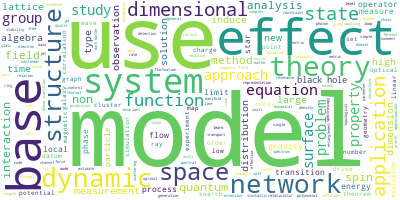

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=100000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_str)
wordcloud.to_image()

## 4. Pembobotan/Vektorisasi dan Perbaikan Data
Menggunakan alat bantu pustaka Gensim.

In [13]:
# bigram and trigrams
bigram_phrases = gensim.models.Phrases(data_words, min_count=100, threshold=1000)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=1000)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigram(texts):
    return(bigram[doc] for doc in texts)

def make_trigrams(texts):
    return(trigram[bigram[doc]] for doc in texts)


data_bigram = make_bigram(data_words)
data_bigram = list(data_bigram)
data_bigram_trigram = make_trigrams(data_bigram)
data_bigram_trigram = list(data_bigram_trigram)


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
print(data_bigram_trigram[0:10])

[['decompose', 'almost', 'complete', 'graph', 'random', 'tree'], ['approximately', 'cost', 'correlate'], ['simple', 'closed', 'geodesic', 'most', 'surface'], ['rate', 'equation'], ['superstring'], ['scale', 'limit', 'threshold', 'window', 'monotone', 'boolean', 'function', 'flip', 'outcome'], ['coexistence', 'double', 'alternate', 'chain', 'vo', 'p_', 'o_', 'study'], ['survey', 'quasar', 'measure', 'mean', 'free', 'path', 'cosmic', 'time'], ['type'], ['ceramic']]


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# tf-idf removal using gensim
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigram_trigram)

texts = data_bigram_trigram

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus=corpus, id2word=id2word)

low_value = 0.03
words = []
words_missing_in_tfidf = []
new_corpus = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    # new_bow = [b for b in bow if b[0] not in low_value_words]
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    # print(low_value_words)
    drops = low_value_words + words_missing_in_tfidf
    # print(drops)
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow
    new_corpus.append(new_bow)


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
print(corpus[0:5])
print(new_corpus[0:5])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)], [(6, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)], [(14, 1), (15, 1)], [(16, 1)]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)], [(6, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)], [(14, 1), (15, 1)], [(16, 1)]]


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 5. Pelatihan Data ke dalam Model dan Perhitungan Coherence Score
Menggunakan alat bantu pustaka Gensim

In [44]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        path = './models/lda-{0}'.format(num_topics)
        model.save(path)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [49]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=101, step=5)

## Visualisasi Hasil clustering
Menggunakan alat bantu pustaka pyLDAvis

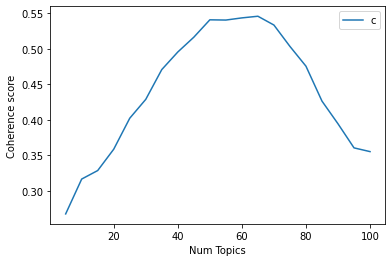

In [ ]:
# Show graph
limit=101; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2674
Num Topics = 10  has Coherence Value of 0.3165
Num Topics = 15  has Coherence Value of 0.3285
Num Topics = 20  has Coherence Value of 0.3586
Num Topics = 25  has Coherence Value of 0.4022
Num Topics = 30  has Coherence Value of 0.4288
Num Topics = 35  has Coherence Value of 0.4708
Num Topics = 40  has Coherence Value of 0.4955
Num Topics = 45  has Coherence Value of 0.5164
Num Topics = 50  has Coherence Value of 0.5409
Num Topics = 55  has Coherence Value of 0.5405
Num Topics = 60  has Coherence Value of 0.5436
Num Topics = 65  has Coherence Value of 0.5459
Num Topics = 70  has Coherence Value of 0.5335
Num Topics = 75  has Coherence Value of 0.5034
Num Topics = 80  has Coherence Value of 0.4755
Num Topics = 85  has Coherence Value of 0.4264
Num Topics = 90  has Coherence Value of 0.3944
Num Topics = 95  has Coherence Value of 0.3605
Num Topics = 100  has Coherence Value of 0.3552


In [ ]:
# Select the model and print the topics
optimal_model = model_list[12]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(17,
  '0.125*"curve" + 0.123*"invariant" + 0.083*"plane" + 0.078*"scheme" + 0.070*"condensate" + 0.070*"signature" + 0.060*"physics" + 0.038*"correlate" + 0.038*"giant" + 0.033*"odd"'),
 (0,
  '0.150*"couple" + 0.110*"polynomial" + 0.110*"scalar" + 0.089*"fluid" + 0.079*"stochastic" + 0.069*"radiation" + 0.051*"oscillator" + 0.051*"absorption" + 0.030*"perfect" + 0.025*"outflow"'),
 (10,
  '0.303*"star" + 0.139*"formation" + 0.093*"gravitational" + 0.051*"amplitude" + 0.050*"relaxation" + 0.031*"frame" + 0.030*"relationship" + 0.024*"subgroup" + 0.020*"discovery" + 0.018*"isolated"'),
 (52,
  '0.207*"interaction" + 0.089*"long" + 0.089*"gas" + 0.057*"efficient" + 0.054*"short" + 0.053*"range" + 0.051*"estimation" + 0.049*"oscillation" + 0.047*"bind" + 0.047*"component"'),
 (18,
  '0.178*"line" + 0.145*"strong" + 0.104*"solar" + 0.084*"probability" + 0.041*"nanowire" + 0.034*"localize" + 0.029*"guide" + 0.027*"construct" + 0.024*"integrate" + 0.022*"unusual"'),
 (29,
  '0.139*"form" +

In [53]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word, mds="mds", R=10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
38    -0.000622  0.142643       1        1  2.488876
50     0.043134  0.178057       2        1  2.428816
42     0.320864  0.040626       3        1  2.274819
27    -0.053892  0.197257       4        1  2.134467
22    -0.021234  0.094109       5        1  2.074611
...         ...       ...     ...      ...       ...
32     0.224257 -0.043969      61        1  1.144857
11    -0.000933 -0.081710      62        1  1.060091
43    -0.013176 -0.090419      63        1  1.027098
18    -0.012187 -0.085392      64        1  0.974570
62     0.079414 -0.092417      65        1  0.898199

[65 rows x 5 columns], topic_info=            Term         Freq        Total Category  logprob  loglift
205        model  2606.000000  2606.000000  Default  10.0000  10.0000
332          use  1576.000000  1576.000000  Default   9.0000   9.0000
68         field  1608.000000  1608.000000  Default   8.0000   8.0000
502          non  1356.000000  1356.000000  Default   7.0000   7.0000
825       effect  1390.000000  1390.000000  Default   6.0000   6.0000
...          ...          ...          ...      ...      ...      ...
1661    globular    87.102955    88.304953  Topic65  -3.1195   4.6988
1167        site    68.381674    69.583672  Topic65  -3.3615   4.6951
328   mesoscopic    64.587005    65.797648  Topic65  -3.4186   4.6940
947        sheet    63.588278    64.790276  Topic65  -3.4342   4.6938
1853      define    61.248931    62.450929  Topic65  -3.4716   4.6931

[714 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1940     43  0.995284       abelian
482      54  0.987681    absorption
231      14  0.985944  acceleration
984      56  0.992526        action
605      49  0.987371        active
...     ...       ...           ...
280      27  0.749416          well
528      58  0.988028         white
1869      5  0.980845          wide
757      41  0.990158          wind
2062     14  0.979678         young

[886 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[39, 51, 43, 28, 23, 27, 7, 29, 31, 54, 60, 5, 10, 6, 41, 65, 32, 16, 42, 3, 50, 22, 46, 26, 9, 45, 52, 48, 47, 53, 2, 20, 61, 24, 36, 34, 49, 37, 55, 15, 17, 62, 64, 38, 25, 14, 13, 58, 56, 11, 4, 57, 59, 1, 18, 21, 8, 30, 40, 35, 33, 12, 44, 19, 63])

### Menyimpan hasil 3 kata teratas setiap topik ke dalam bentuk .csv

In [61]:
top_words_per_topic = []
for t in range(optimal_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in optimal_model.show_topic(t, topn = 3)])

top_words = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])
top_words.to_csv("top_words.csv")
top_words

,Topic,Word,P
0,0,couple,0.149800
1,0,polynomial,0.110377
2,0,scalar,0.109734
3,1,application,0.220772
4,1,gauge,0.090937
...,...,...,...
190,63,finite,0.129164
191,63,note,0.101804
192,64,spin,0.272800
193,64,geometry,0.099912
